Lambda School Data Science

*Unit 2, Sprint 2, Module 2*

---

# Random Forests

## Assignment
- [ ] Read [“Adopting a Hypothesis-Driven Workflow”](https://outline.com/5S5tsB), a blog post by a Lambda DS student about the Tanzania Waterpumps challenge.
- [ ] Continue to participate in our Kaggle challenge.
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features.
- [ ] Try Ordinal Encoding.
- [ ] Try a Random Forest Classifier.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.

## Stretch Goals

### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Do more exploratory data analysis, data cleaning, feature engineering, and feature selection.
- [ ] Try other [categorical encodings](https://contrib.scikit-learn.org/categorical-encoding/).
- [ ] Get and plot your feature importances.
- [ ] Make visualizations and share on Slack.

### Reading

Top recommendations in _**bold italic:**_

#### Decision Trees
- A Visual Introduction to Machine Learning, [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/),  and _**[Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)**_
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU)

#### Random Forests
- [_An Introduction to Statistical Learning_](http://www-bcf.usc.edu/~gareth/ISL/), Chapter 8: Tree-Based Methods
- [Coloring with Random Forests](http://structuringtheunstructured.blogspot.com/2017/11/coloring-with-random-forests.html)
- _**[Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)**_

#### Categorical encoding for trees
- [Are categorical variables getting lost in your random forests?](https://roamanalytics.com/2016/10/28/are-categorical-variables-getting-lost-in-your-random-forests/)
- [Beyond One-Hot: An Exploration of Categorical Variables](http://www.willmcginnis.com/2015/11/29/beyond-one-hot-an-exploration-of-categorical-variables/)
- _**[Categorical Features and Encoding in Decision Trees](https://medium.com/data-design/visiting-categorical-features-and-encoding-in-decision-trees-53400fa65931)**_
- _**[Coursera — How to Win a Data Science Competition: Learn from Top Kagglers — Concept of mean encoding](https://www.coursera.org/lecture/competitive-data-science/concept-of-mean-encoding-b5Gxv)**_
- [Mean (likelihood) encodings: a comprehensive study](https://www.kaggle.com/vprokopev/mean-likelihood-encodings-a-comprehensive-study)
- [The Mechanics of Machine Learning, Chapter 6: Categorically Speaking](https://mlbook.explained.ai/catvars.html)

#### Imposter Syndrome
- [Effort Shock and Reward Shock (How The Karate Kid Ruined The Modern World)](http://www.tempobook.com/2014/07/09/effort-shock-and-reward-shock/)
- [How to manage impostor syndrome in data science](https://towardsdatascience.com/how-to-manage-impostor-syndrome-in-data-science-ad814809f068)
- ["I am not a real data scientist"](https://brohrer.github.io/imposter_syndrome.html)
- _**[Imposter Syndrome in Data Science](https://caitlinhudon.com/2018/01/19/imposter-syndrome-in-data-science/)**_


### More Categorical Encodings

**1.** The article **[Categorical Features and Encoding in Decision Trees](https://medium.com/data-design/visiting-categorical-features-and-encoding-in-decision-trees-53400fa65931)** mentions 4 encodings:

- **"Categorical Encoding":** This means using the raw categorical values as-is, not encoded. Scikit-learn doesn't support this, but some tree algorithm implementations do. For example, [Catboost](https://catboost.ai/), or R's [rpart](https://cran.r-project.org/web/packages/rpart/index.html) package.
- **Numeric Encoding:** Synonymous with Label Encoding, or "Ordinal" Encoding with random order. We can use [category_encoders.OrdinalEncoder](https://contrib.scikit-learn.org/categorical-encoding/ordinal.html).
- **One-Hot Encoding:** We can use [category_encoders.OneHotEncoder](http://contrib.scikit-learn.org/categorical-encoding/onehot.html).
- **Binary Encoding:** We can use [category_encoders.BinaryEncoder](http://contrib.scikit-learn.org/categorical-encoding/binary.html).


**2.** The short video 
**[Coursera — How to Win a Data Science Competition: Learn from Top Kagglers — Concept of mean encoding](https://www.coursera.org/lecture/competitive-data-science/concept-of-mean-encoding-b5Gxv)** introduces an interesting idea: use both X _and_ y to encode categoricals.

Category Encoders has multiple implementations of this general concept:

- [CatBoost Encoder](http://contrib.scikit-learn.org/categorical-encoding/catboost.html)
- [James-Stein Encoder](http://contrib.scikit-learn.org/categorical-encoding/jamesstein.html)
- [Leave One Out](http://contrib.scikit-learn.org/categorical-encoding/leaveoneout.html)
- [M-estimate](http://contrib.scikit-learn.org/categorical-encoding/mestimate.html)
- [Target Encoder](http://contrib.scikit-learn.org/categorical-encoding/targetencoder.html)
- [Weight of Evidence](http://contrib.scikit-learn.org/categorical-encoding/woe.html)

Category Encoder's mean encoding implementations work for regression problems or binary classification problems. 

For multi-class classification problems, you will need to temporarily reformulate it as binary classification. For example:

```python
encoder = ce.TargetEncoder(min_samples_leaf=..., smoothing=...) # Both parameters > 1 to avoid overfitting
X_train_encoded = encoder.fit_transform(X_train, y_train=='functional')
X_val_encoded = encoder.transform(X_train, y_val=='functional')
```

For this reason, mean encoding won't work well within pipelines for multi-class classification problems.

**3.** The **[dirty_cat](https://dirty-cat.github.io/stable/)** library has a Target Encoder implementation that works with multi-class classification.

```python
 dirty_cat.TargetEncoder(clf_type='multiclass-clf')
```
It also implements an interesting idea called ["Similarity Encoder" for dirty categories](https://www.slideshare.net/GaelVaroquaux/machine-learning-on-non-curated-data-154905090).

However, it seems like dirty_cat doesn't handle missing values or unknown categories as well as category_encoders does. And you may need to use it with one column at a time, instead of with your whole dataframe.

**4. [Embeddings](https://www.kaggle.com/learn/embeddings)** can work well with sparse / high cardinality categoricals.

_**I hope it’s not too frustrating or confusing that there’s not one “canonical” way to encode categoricals. It’s an active area of research and experimentation! Maybe you can make your own contributions!**_

### Setup

You can work locally (follow the [local setup instructions](https://lambdaschool.github.io/ds/unit2/local/)) or on Colab (run the code cell below).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split

train_original = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train_original.shape, test.shape

((59400, 41), (14358, 40))

In [0]:
#okay lets get that validation set
train, val = train_test_split(train_original, train_size = 0.80, test_size = .20,
                              stratify = train_original['status_group'], 
                              random_state = 42)

train.shape, val.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

In [0]:
train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
43360,72938,0.0,2011-07-27,NaN,0,NaN,33.542898,-9.174777,Kwa Mzee Noa,0,Lake Nyasa,Mpandapanda,Mbeya,12,4,Rungwe,Kiwira,0,True,GeoData Consultants Ltd,VWC,K,NaN,0,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,functional
7263,65358,500.0,2011-03-23,Rc Church,2049,ACRA,34.665760,-9.308548,Kwa Yasinta Ng'Ande,0,Rufiji,Kitichi,Iringa,11,4,Njombe,Imalinyi,175,True,GeoData Consultants Ltd,WUA,Tove Mtwango gravity Scheme,True,2008,gravity,gravity,gravity,wua,user-group,pay monthly,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
2486,469,25.0,2011-03-07,Donor,290,Do,38.238568,-6.179919,Kwasungwini,0,Wami / Ruvu,Kwedigongo,Pwani,6,1,Bagamoyo,Mbwewe,2300,True,GeoData Consultants Ltd,VWC,NaN,False,2010,india mark ii,india mark ii,handpump,vwc,user-group,pay per bucket,per bucket,salty,salty,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional
313,1298,0.0,2011-07-31,Government Of Tanzania,0,DWE,30.716727,-1.289055,Kwajovin 2,0,Lake Victoria,Kihanga,Kagera,18,1,Karagwe,Isingiro,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,other,other,other,vwc,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other,non functional
52726,27001,0.0,2011-03-10,Water,0,Gove,35.389331,-6.399942,Chama,0,Internal,Mtakuj,Dodoma,1,6,Bahi,Nondwa,0,True,GeoData Consultants Ltd,VWC,Zeje,True,0,mono,mono,motorpump,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,functional


In [0]:
train.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group'],
      dtype='object')

In [0]:
#side note, I'm really glad to see some of the stuff wrangled and caugh last
#assignment showed up in lecture notebook.  Glad to know I'm on the right track
import numpy as np


def wrangle(df):

  #deep copy since we are changing values and the shape of our data. Don't want
  #any warnings.
  df = df.copy()

  #Changing the almost zeros to zero on latitude.  Zero latitude is definitely
  #a mistake, as it is on another part of the world

  df['latitude'] = df['latitude'].replace(-2e08, 0)

  #last assignment I explored and found what columns had too many zeros, so we
  #are just going to build off that.
  columns = ['gps_height', 'longitude', 'latitude', 'population', 
             'construction_year']

  for column in columns:
    df[column].replace(0, np.nan, inplace = True)

    #I'm taking this from the lecture note book.  I suspect what we are doing
    #is creating a boolean column, to identify which of our data is collected
    #vs imputed(happening later in the pipeline).  Then our model may make
    #better decisions, because it can weigh the importance of imputed vs
    #collected data.  Just a theory.

    #quote from Xander: missing values may be a predictive signal
    df[column+'_MISSING'] = df[column].isnull()

  #drop the dupes
  df.drop(columns = ['quantity_group', 'payment_type'], inplace = True)

  #drop never varying, and always varying columns
  df.drop(columns = ['recorded_by', 'id'], inplace = True)

  #Convert date_recorded to dattime
  df['date_recorded'] = pd.to_datetime(df['date_recorded'], 
                                       infer_datetime_format = True)
  
  #making date more usable by extracting month, day and year
  df['year_recorded'] = df['date_recorded'].dt.year
  df['month_recorded'] = df['date_recorded'].dt.month
  df['day_recorded'] = df['date_recorded'].dt.day

  #dropping the datetime column
  df.drop(columns = 'date_recorded', inplace = True)

  #Cool feature I'm borrowing from class: How many years from construction to
  #date recorded
  df['years'] = df['year_recorded'] - df['construction_year']
  df['years_MISSING'] = df['years'].isnull()

  return df

In [0]:
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

#Baseline
Okay, I'm going to use an mvp based off our lecture notes as my baseline.  I will then form some hypothesis, test them, and incorporate them into my final model.  Hopefully through this iterative process I can improve my accuracy.

In [0]:
#since we are doing ordinal encoding, all I really need is to identify my target
target = 'status_group'

X_train = train.drop(columns = target)
y_train = train[target]
X_val = val.drop(columns = target)
y_val = val[target]
#no need to drop from test features, it is already dropped.

In [0]:
X_train.shape, X_val.shape, test.shape

((47520, 45), (11880, 45), (14358, 45))

In [0]:
%%time

import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy = 'mean'),
    RandomForestClassifier(n_jobs = -1, random_state = 42)
)

pipeline.fit(X_train, y_train)
print('Training Accuracy: ', pipeline.score(X_train, y_train))
print('Validation Accuracy: ', pipeline.score(X_val, y_val))

Training Accuracy:  0.9999789562289563
Validation Accuracy:  0.8104377104377104
CPU times: user 21 s, sys: 262 ms, total: 21.3 s
Wall time: 11.9 s


In [0]:
y_pred = pipeline.predict(test)

submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('forest_submission_2.csv', index = False)

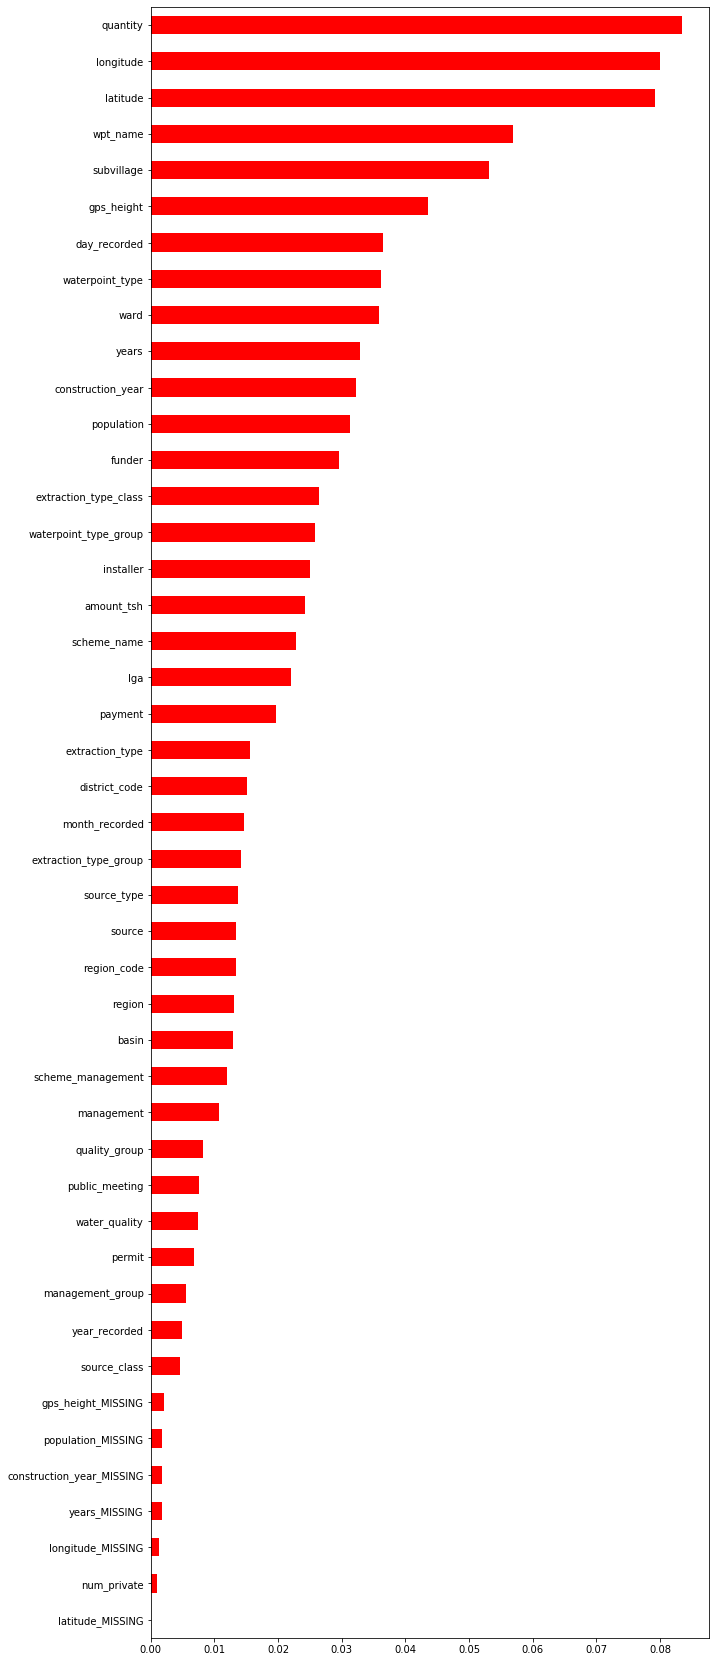

In [0]:
import matplotlib.pyplot as plt

model = pipeline.named_steps['randomforestclassifier']
encoder = pipeline.named_steps['ordinalencoder']

encoded_columns = encoder.transform(X_val).columns
coefficients = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize = (10, 30))
coefficients.sort_values().plot.barh(color = 'red');

#Hypothesis #1
Target Encoding will improved accuracy over ordinal encoding.

In [0]:
%%time

for i in range(2, 20, 5):
  for j in range(1, 20, 5):

    encoder = ce.TargetEncoder(min_samples_leaf = i, smoothing = j)

    X_train_encoded = encoder.fit_transform(X_train, y_train == 'functional')
    X_val_encoded = encoder.transform(X_val)

    pipeline = make_pipeline(
        SimpleImputer(strategy = 'mean'),
        RandomForestClassifier(n_jobs = -1, random_state = 42)
    )

    pipeline.fit(X_train_encoded, y_train)
    print('min_samples_leaf: ', i)
    print('smoothing: ', j)
    print('Training Accuracy: ', pipeline.score(X_train_encoded, y_train))
    print('Validation Accuracy: ', pipeline.score(X_val_encoded, y_val))

min_samples_leaf:  2
smoothing:  1
Training Accuracy:  0.9998947811447811
Validation Accuracy:  0.7861111111111111
min_samples_leaf:  2
smoothing:  6
Training Accuracy:  0.9999158249158249
Validation Accuracy:  0.7861952861952862
min_samples_leaf:  2
smoothing:  11
Training Accuracy:  0.9999158249158249
Validation Accuracy:  0.7858585858585858
min_samples_leaf:  2
smoothing:  16
Training Accuracy:  0.9999158249158249
Validation Accuracy:  0.7857744107744108
min_samples_leaf:  7
smoothing:  1
Training Accuracy:  0.9999158249158249
Validation Accuracy:  0.7940235690235691
min_samples_leaf:  7
smoothing:  6
Training Accuracy:  0.9999158249158249
Validation Accuracy:  0.7927609427609428
min_samples_leaf:  7
smoothing:  11
Training Accuracy:  0.9998947811447811
Validation Accuracy:  0.7874579124579124
min_samples_leaf:  7
smoothing:  16
Training Accuracy:  0.9999158249158249
Validation Accuracy:  0.788973063973064
min_samples_leaf:  12
smoothing:  1
Training Accuracy:  0.9998737373737374
Va

#Conclusion 1
Unconfigured it didn't increase my accuracy, but after some reading I realized that I need to tweak the hyper parameters, and that it isn't really an encoder you can just "set and forget".  So I jumped in and started tweaking.
I couldn't get much better than 78% So hypothesis failed, Target Encoding will
be dropped

#Hypothesis 2
Weight of Evidence encoder will improve accuracy.

In [0]:
%%time


encoder = ce.woe.WOEEncoder(handle_missing = 'return_nan')

X_train_encoded = encoder.fit_transform(X_train, y_train == 'functional')
X_val_encoded = encoder.transform(X_val)

pipeline = make_pipeline(
    SimpleImputer(strategy = 'mean'),
    RandomForestClassifier(n_jobs = -1, random_state = 42)
)

pipeline.fit(X_train_encoded, y_train)
print('Training Accuracy: ', pipeline.score(X_train_encoded, y_train))
print('Validation Accuracy: ', pipeline.score(X_val_encoded, y_val))

Training Accuracy:  0.9999158249158249
Validation Accuracy:  0.7892255892255893
CPU times: user 22.4 s, sys: 245 ms, total: 22.6 s
Wall time: 13 s


#Conclusion 2
Again didn't increase the accuracy.  Going to stick with ordinal encoder, and try a different strategy.

#Hypothesis 3
Feature engineering based off the top three features graphed above will increase accuracy.

In [0]:
#so we have quantity, latitutde, and longitude.
#so I know from past assignments that quantity_dry is the most predictive part
#of the quantity column.  So I wonder if distance from a dry well could be
#predictive.  Like say maybe a the well's dryness is not strictly a mechanical
#feature, but could be a location feature (like the watershed in that area
#is dried up). I think latitude and longitude being the second best predictors
#might actually suggest that as well.

#so maybe what I do, is create a df of only the dry wells, and their lat/long
#positions.  Then every well should have a distance to the nearest dry well
#that is not itself.  That becomes its own column, distance to nearest drywell

In [0]:
#to do th is I need to change my wrangle function, or just cut out the snippets
#that I need from my original wrangle function and do them here.  Based off the
#logic we used above, it won't hurt to wrangle and impute one column, and do it
#again, because latt & long deal with zeros, once they are replaced, it will
#have no values to change.

eng_df = train_original.copy()

eng_df['latitude'] = eng_df['latitude'].replace(-2e08, 0)

eng_df['latitude'].replace(0, np.nan, inplace = True)
eng_df['longitude'].replace(0, np.nan, inplace = True)

print(eng_df.shape)
print(eng_df['latitude'].isnull().sum())
print(eng_df['longitude'].isnull().sum())

(59400, 41)
0
1812


In [0]:
#should I impute here or in my pipeline?

#no choice is perfect, so I will elect to yeet the data, and impute here.  Then
#I can use the ID to prevent any crazy distances (like a drywell thinking it is
#closest to itself because I was off by a few hundred meters or something)

eng_df['longitude'].fillna(eng_df['longitude'].mean(), inplace = True)

In [0]:
id_series = eng_df[eng_df['quantity'] == 'dry']['id']

dry_well = wrangle(eng_df)

dry_well = dry_well[dry_well['quantity'] == 'dry']

dry_well = dry_well[['quantity', 'latitude', 'longitude']]

print(dry_well.shape, id_series.shape)
dry_well.head()

(6246, 3) (6246,)


,quantity,latitude,longitude
3,dry,-11.155298,38.486161
16,dry,-9.106185,34.642439
17,dry,-9.085515,34.569266
36,dry,-9.638520,33.854345
43,dry,-4.628921,34.967789


In [0]:
id_series.head()

3     67743
16    48451
17    58155
36    67359
43    19282
Name: id, dtype: int64

In [0]:
dry_well['id'] = id_series
print(dry_well.shape)
dry_well.head()

(6246, 4)


,quantity,latitude,longitude,id
3,dry,-11.155298,38.486161,67743
16,dry,-9.106185,34.642439,48451
17,dry,-9.085515,34.569266,58155
36,dry,-9.638520,33.854345,67359
43,dry,-4.628921,34.967789,19282


In [0]:
print(dry_well['longitude'].mean())
dry_well.isnull().sum()

35.18705994903243


quantity     0
latitude     0
longitude    0
id           0
dtype: int64

In [0]:
#going to need a few more tools to do this.  Geopandas can use points and
#shapely to find the nearest points. Its tuned to making these operations faster
#than anything i could make for this assignment.
from shapely.ops import nearest_points
from shapely.geometry import Point
!pip install geopandas
import geopandas as gpd

columns = list(dry_well.columns)

gpd_dry_well = gpd.GeoDataFrame(dry_well, 
                                geometry = gpd.points_from_xy(dry_well['longitude'],
                                                                    dry_well['latitude']))
gpd_eng_df = gpd.GeoDataFrame(eng_df[columns],
                              geometry = gpd.points_from_xy(eng_df['longitude'],
                                                                  eng_df['latitude']))

print(gpd_dry_well.shape, gpd_eng_df.shape)
gpd_dry_well.head()

(6246, 5) (59400, 5)


,quantity,latitude,longitude,id,geometry
3,dry,-11.155298,38.486161,67743,POINT (38.48616 -11.15530)
16,dry,-9.106185,34.642439,48451,POINT (34.64244 -9.10618)
17,dry,-9.085515,34.569266,58155,POINT (34.56927 -9.08551)
36,dry,-9.638520,33.854345,67359,POINT (33.85434 -9.63852)
43,dry,-4.628921,34.967789,19282,POINT (34.96779 -4.62892)


In [0]:
gpd_eng_df.head()

,quantity,latitude,longitude,id,geometry
0,enough,-9.856322,34.938093,69572,POINT (34.93809 -9.85632)
1,insufficient,-2.147466,34.698766,8776,POINT (34.69877 -2.14747)
2,enough,-3.821329,37.460664,34310,POINT (37.46066 -3.82133)
3,dry,-11.155298,38.486161,67743,POINT (38.48616 -11.15530)
4,seasonal,-1.825359,31.130847,19728,POINT (31.13085 -1.82536)


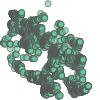

In [0]:
gpd_dry_well['geometry'].unary_union

In [0]:
#okay, so comparing the point of the 0th index, to all the points in gpd_dry_well
#to find the nearest point (index 0).  I want to find the distance between these
#two points.  I wonder if I can cast them to let geopy distance calculate the
#distance in KM.

type(nearest_points(gpd_eng_df.loc[0]['geometry'], gpd_dry_well['geometry'].unary_union)[0])

shapely.geometry.point.Point

In [0]:
nearest_points(gpd_eng_df.loc[0]['geometry'], gpd_dry_well['geometry'].unary_union)[0].x

34.93809275

In [0]:
#geopy distance will not take shapely distance.  But it calculates a much more
#accurate distance than either shapely, or geopandas (which uses shapely methods
#).  So I need to extract the shapely points, and put them into a tuple for
#distance to work.  Casting directly to tuple doesn't work, because shapely
#points aren't iterable.  My god what did I get into.
from geopy.distance import distance

a, b = nearest_points(gpd_eng_df.loc[0]['geometry'], gpd_dry_well['geometry'].unary_union)

a = (a.x, a.y)
b = (b.x, b.y)

distance(a, b).km

0.5571323342936498

In [0]:
#holy smokes, proof of concept.  Now lets wrap this up.  Good lord I spent so
#much time on this feature. I'm going to be so bummed if this doesn't increase
#my accuracy lol.



In [0]:
#okay we got your geo dataframes with only the info we need.
#so next I need to.  Going to need a to make a cool function to do this
#I need to make sure that when I use this, that the pts is made from a data
#frame that excludes the point we are looking at.

def dist_from_dry_well(row):
  '''
  returns the distance from a water pump, and the nearest dry pump/well
  does this by taking in a row from out data frame, extracting the point
  from that row, then makes a shapely unary_union of the dry_well dataframe
  with that entry filtered out by 'id' (to avoid matching with self)  Returns
  the distance in km
  '''

  point = row['geometry']

  pts = gpd_dry_well[gpd_dry_well['id'] != row['id']].unary_union

  #here we identify the row that nearest dry_well to our point belongs to.
  #we can use this to verify that we have not matched with ourselves.
  a, b = nearest_points(point, pts)
  
  #identifying the row in the dry_well data frame that was matched.  I'm doing
  #this strictly to identify if we self matched.  In theory we will never
  #self match.  Just being careful.
  #nearest = gpd_dry_well['geometry'] == b
  

  # if gpd_dry_well[nearest]['id'] == row['id']:
  #   print('Warning: points are matching with self.')
  #   print('pass in a filtered point list')

  

  a = (a.x, a.y)
  b = (b.x, b.y)

  return distance(a, b).km

In [0]:
#lets do it.
%%time

distances = gpd_eng_df.apply(dist_from_dry_well, axis = 1)

distances.head()

CPU times: user 56min 3s, sys: 3.28 s, total: 56min 6s
Wall time: 56min 8s


In [0]:
distances.head()

0     0.557132
1    22.905807
2    45.179911
3     0.147508
4     7.753742
dtype: float64

In [0]:
eng_df['distance_from_dry_pump'] = distances
eng_df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,distance_from_dry_pump
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,0.557132
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,22.905807
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional,45.179911
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,0.147508
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,7.753742


In [0]:
train, val = train_test_split(eng_df, train_size = 0.80, test_size = .20,
                              stratify = train_original['status_group'], 
                              random_state = 42)
train.shape, val.shape

((47520, 42), (11880, 42))

In [0]:
train = wrangle(train)
val = wrangle(val)

train.shape, val.shape

((47520, 47), (11880, 47))

In [0]:
target = 'status_group'

X_train = train.drop(columns = target)
y_train = train[target]
X_val = val.drop(columns = target)
y_val = val[target]

In [0]:
%%time

import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy = 'mean'),
    RandomForestClassifier(n_jobs = -1, random_state = 42)
)

pipeline.fit(X_train, y_train)
print('Training Accuracy: ', pipeline.score(X_train, y_train))
print('Validation Accuracy: ', pipeline.score(X_val, y_val))

Training Accuracy:  0.9999579124579124
Validation Accuracy:  0.8104377104377104
CPU times: user 21.5 s, sys: 322 ms, total: 21.9 s
Wall time: 12.2 s


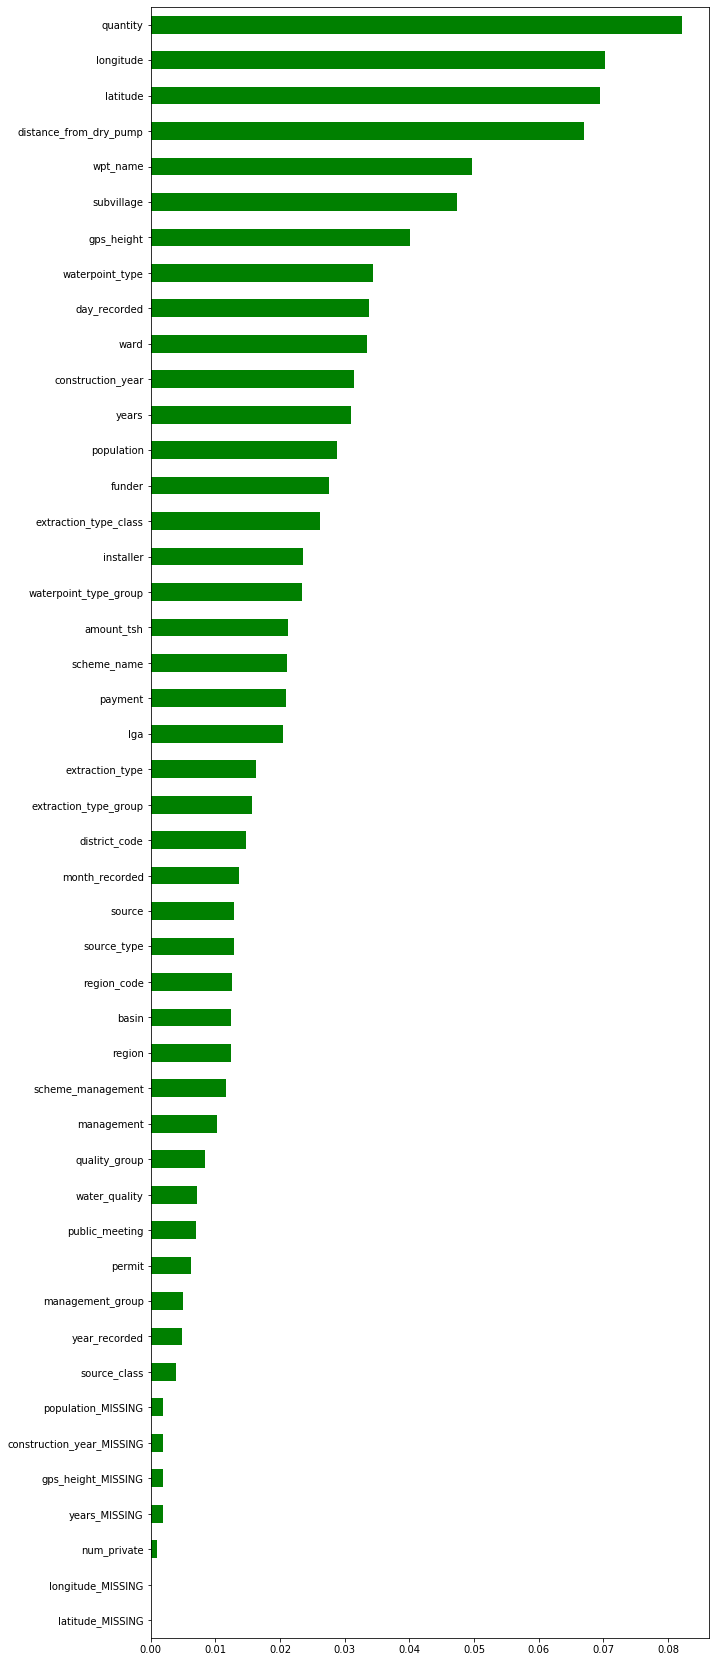

In [0]:
import matplotlib.pyplot as plt

model = pipeline.named_steps['randomforestclassifier']
encoder = pipeline.named_steps['ordinalencoder']

encoded_columns = encoder.transform(X_val).columns
coefficients = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize = (10, 30))
coefficients.sort_values().plot.barh(color = 'green');

#Conclusion 3
It didn't improve my model.  Unable to improve on my baseline, I'm sticking with that.